<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-theory" data-toc-modified-id="Introduction-and-theory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and theory</a></span></li><li><span><a href="#Developing-a-WCM-version-with-Jacobian" data-toc-modified-id="Developing-a-WCM-version-with-Jacobian-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Developing a WCM version with Jacobian</a></span><ul class="toc-item"><li><span><a href="#Some-further-remarks" data-toc-modified-id="Some-further-remarks-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Some further remarks</a></span></li></ul></li><li><span><a href="#Extracting-data" data-toc-modified-id="Extracting-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extracting data</a></span><ul class="toc-item"><li><span><a href="#Field-and-Sentinel-1-data" data-toc-modified-id="Field-and-Sentinel-1-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Field and Sentinel 1 data</a></span></li><li><span><a href="#The-Sentinel2-retrieved-parameters-from-KaSKA" data-toc-modified-id="The-Sentinel2-retrieved-parameters-from-KaSKA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The Sentinel2 retrieved parameters from KaSKA</a></span></li></ul></li></ul></div>

In [1]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model
from SAR_retrieval_funcs import invert_field, do_plots, prepare_field_data

# Combined retrieval from S1 and S2

## Introduction and theory
Most forms of the water cloud model tend to ignore multiple scattering terms, and thus have two contributions:

1. a canopy scattering contribution and,
2. a soil contribution, attenuated by the two way canopy path.

The general expression is

$$
\sigma_{pp}^{0} = \frac{1}{2}\omega_{c}\cos\theta\left[1-\exp\left(-\frac{2BV_2}{\cos\theta}\right)\right] + \exp\left(-\frac{2BV_2}{\cos\theta}\right)\sigma_{soil}^{0}.
$$

where $\omega_c$ is the canopy scattering term, $V_2$ is the equivalent canopy optical depth, $\mu=\cos\theta$ is the cosine of the angle of incidence and $\sigma_{soil}^{0}$ is the soil backscattering coefficient. $B$ is an empirical constant that mostly relates to the extinction of radiation through the canopy, and usually, $\omega_c=A\cdot V_1$, or in other words, the canopy scattering term is just an empirical scaling of some vegetation optical depth.

## Developing a WCM version with Jacobian

We'll develop some expressions for a WCM model with a Jacobian, as we'll be seeking to fit the WCM to observations and infer parameters.

For completeness, the WCM definition is as follows:

$$
\sigma_{pp}^{0} = A\cdot V_{1}\left[1 - \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\cdot\left(C + D\cdot M_{v}\right).
$$

The previous definition assumes that the soil backscatter can be modelled as a linear function. Clearly more sophisticated options can be deployed, but if we start with something simple like this, we can then directly retrieve $\sigma_{soil}$ and invert it in a second pass.

The derivatives are given below. Not strictly needed, but useful if we're going to minimise some form of cost function.. We first define a few convenience symbols.

$$
\begin{align*}
\sigma_{soil} &= C + D\cdot M_{v}\\
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial \sigma_{pp}^{0}}{\partial A} &= V_{1} - V_{1}\tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial B} &= \frac{-2V_2}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pp}^{0}}{\partial C} &= \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial D} &= M_{v}\cdot \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial M_{v}} &= D\cdot \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial V_{1}} &= A - A\tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial V_{2}} &= \frac{-2B}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\end{align*}
$$


Because we're at it, we might as well develop expressions for the Hessian that might allow quick exploitation of Newton methods.


$$
\begin{align}
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial B} &= \frac{2V_1 V_2}{\mu}\tau \\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial S} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial A} &= \frac{2V_1 V_2}{\mu}\tau \\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial B} &= \frac{(4 (C + S - A V_1) V_2^2}{\mu^2}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial C} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial S} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial B} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial S} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial B} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial S} &= 0\\
\end{align}
$$

### Some further remarks

It is entirely possible to approximate the model above via a linear polynomial. The way to do this is to expand the first equation with a MacLaurin series. In order to deal with the non-linearity, you need some 3 to 4 terms, but this is dependent on the different model parameters. Left here as a footnote.

## Extracting data

### Field and Sentinel 1 data

This is all coming from a CSV file. The next few blocks/cells do some first plotting of the data...

In [2]:
chunk = """;301;301;301;301;301;301;301;301;301;301;301;301;508;508;508;508;508;508;508;508;508;508;508;508;542;542;542;542;542;542;542;542;542;542;542;542;319;319;319;319;319;319;319;319;319;319;319;319;515;515;515;515;515;515;515;515;515;515;515;515
;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv
"""
fields = chunk.split("\n")[0].split(";")[1:]
col_names = [f"{col:s}_{fields[i]:s}" for i,
             col in enumerate(chunk.split("\n")[1].split(";")[1:])]

df = pd.read_csv("multi.csv", skiprows=2, sep=";", names=col_names)
fields = ["301", "508", "542", "319", "515"]

for field in fields:
    df[f"doy_{field:s}"] = pd.to_datetime(df[f'date_{field:s}']).dt.dayofyear

Text(0.5, 0, 'DoY/2017')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


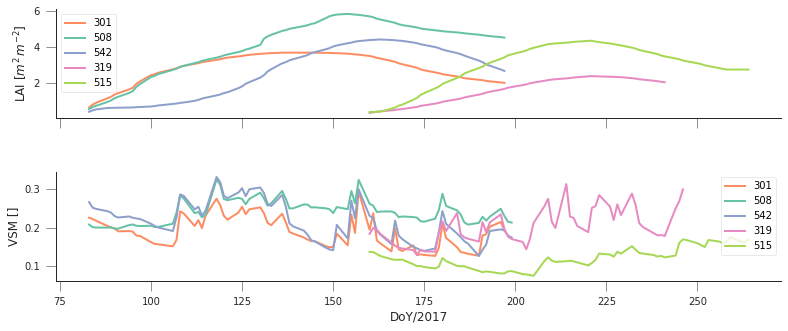

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], df[f"LAI_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")


axs[0].set_ylabel(r"LAI $[m^2\,m^{-2}]$")
axs[1].set_ylabel("VSM []")
axs[1].set_xlabel("DoY/2017")

The above plots show clear phenology diffrences between summer and winter crops, and a surprising amount of variation in soil moisture, although the peaks (hypothesising here that these are due to rainfall events) show a lot of commonality. 

Let's plot the backscatter. Broadly speaking, the ratio of VH/VV should follow a trend that might be linked to volumetric scattering, and hence vegetation optical depth, and hence some form of LAI...

/home/tweiss/anaconda37/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'DoY/2017')

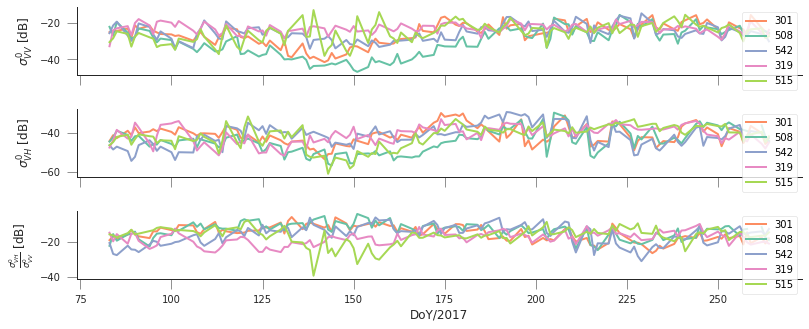

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vv_{field:s}"]),
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vh_{field:s}"]),
                          label=field))

    l3.append(axs[2].plot(df[f"doy_{field:s}"], 10*np.log(
        df[f"vh/vv_{field:s}"]),
        label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
axs[1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
axs[2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
axs[2].set_xlabel("DoY/2017")

You may need to squint your eyes a bit ;-)

### The Sentinel2 retrieved parameters from KaSKA

We have used KaSKA to retrieve land surface parameters. These are provided on a 20m resolution grid and are reported every 5 days. I have averaged them over each field. Note that this might have actually included some boundary pixels, but hey...

Let's have a look at how things stack up.

(0, 1)

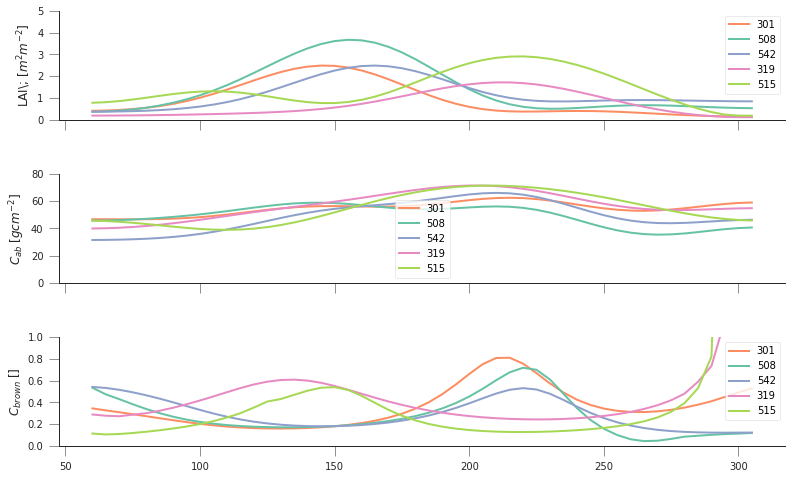

In [5]:
df_s2 = pd.read_csv("LMU_S2_field_retrievals.csv", sep=";")
df_s2['doy'] = pd.to_datetime(df_s2.dates).dt.dayofyear
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 8))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df_s2.doy, df_s2[f"lai_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df_s2.doy, df_s2[f"cab_{field:s}"],
                          label=field))
    l3.append(axs[2].plot(df_s2.doy, df_s2[f"cbrown_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"LAI\; $[m^{2}m^{-2}]$")
axs[1].set_ylabel(r"$C_{ab}\;[gcm^{-2}]$")
axs[2].set_ylabel(r"$C_{brown}\;[]$")
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 80)
axs[2].set_ylim(0, 1)

Mostly, LAI appears to be underestimated, and is clearly oversmoothed, but other than that, temporal trends look fairly plausible.

# Inversion strategy

The main assumptions we are making are

* $V_1=V_2=LAI$ This might require further refinement, but basically, $V_i$ are canopy optical thickness
* Assume that there's a strong correlation between $\sigma_{soil}$ in VV and VH polarisations
* If we exploit the S2 LAI data and some uncertainty, we might want to let it float (e.g. update it with the S1 data). There's a risk that we compensate WCM model limitations by changing LAI, so we probably want to keep LAI uncertainty "manageable" (low!)
* We might want to assume smoothness in LAI, but not in soil moisture (it's clearly peaky for rainfall events)
* We don't really have a clue about $A_{pq}$, $B_{pq}$ and $C_{pq}$ parameters. We may have a first guess on $\sigma_{soil}$ when $LAI$ is low, and one could probably make a similar claim for $A\cdot V_1$. 
* The last point is just a trick to get a starting point for the minimisation, but ideally, we'd like to have some form of prior PDF for the WCM parameters.

All this is implemented in a bunch of functions, but the one you may want to look at with more pause is rather unsurprisingly `cost_function`, which bundles everything together. The uncertainty in SAR has been assumed to be 0.5 dB, but that can obviously be changed to deal with changes in speckle filtering and stuff like that.

Let's see how this works for the different fields...

In [6]:
field = "508"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.2, ]*n_obs])
gamma = 50
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

/home/tweiss/anaconda37/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: too many values to unpack (expected 9)

Above, the uncertainty in LAI has been set to 0.2, and the amount of smoothing to 50. The prior mean and std dev for soil moisture has been set to the average of all fields and to some ridiculous high uncertainty. The first interesting thing is that within the canopy period (Doy 100 to 175), the results for SM are quite credible. We also see that the SAR data suggests the LAI is might be too late, and reduces it around DoY 160. 

Outside the canopy period, the model does go a bit crazy. We can see that the goodness of fit is worse, and that the parameters are jumping around, so it suggests that other non-modelled effects are at play here.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 8474.36
Final cost 2590.33


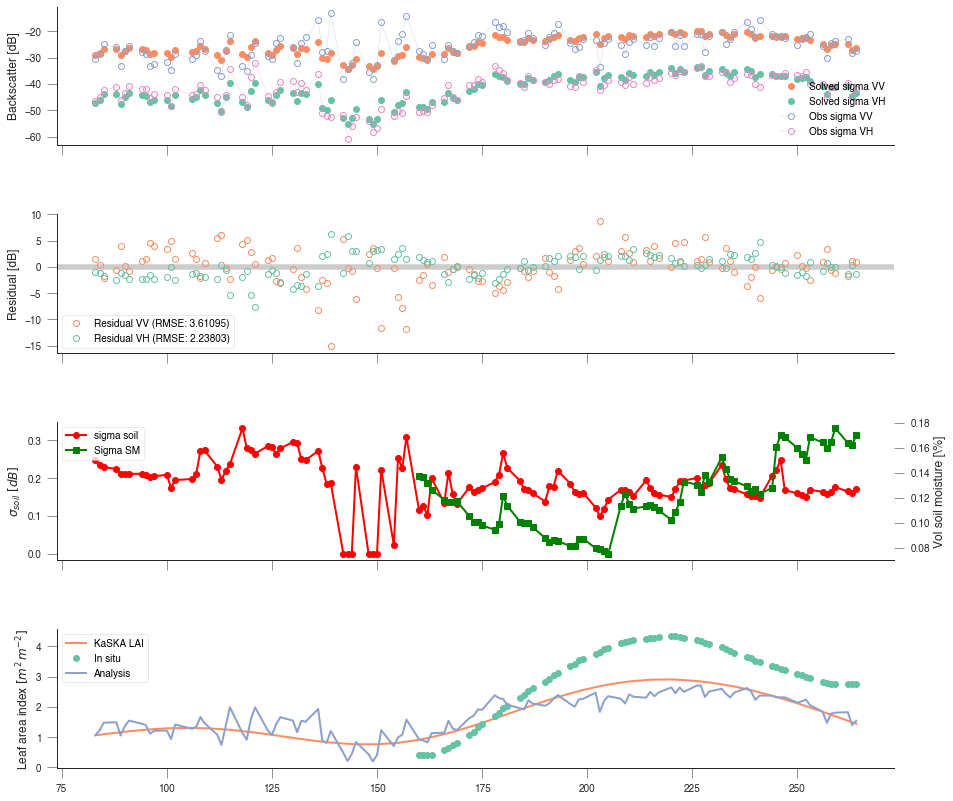

In [9]:
field = "515"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Similar to the previous field, results appear sensible in the vegetation period, but crazy otherwise. We also note that the S2 LAI is  OK in terms of shape, but quite low in absolute value.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 5147.96
Final cost 1706.13


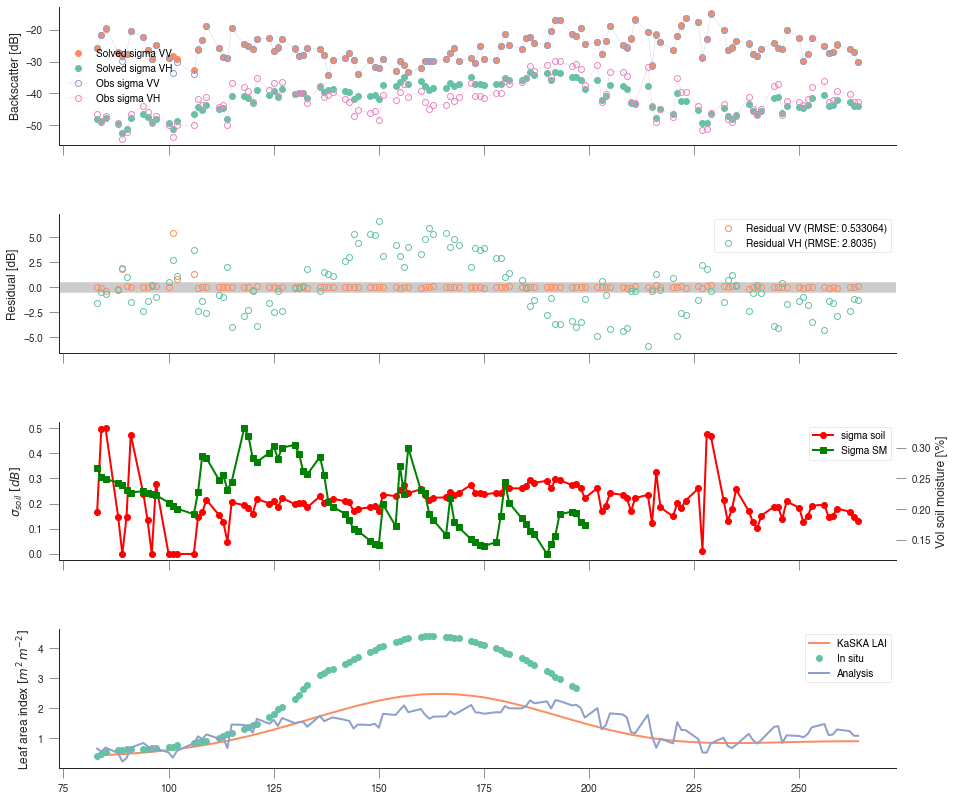

In [10]:
field = "542"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 5
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

This one takes for ever to minimise, so possibly we can expect some numerical issues at play. This probably explains the poor VH fitting (I mean...). Probably a duffer.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 7620.54
Final cost 2343.46


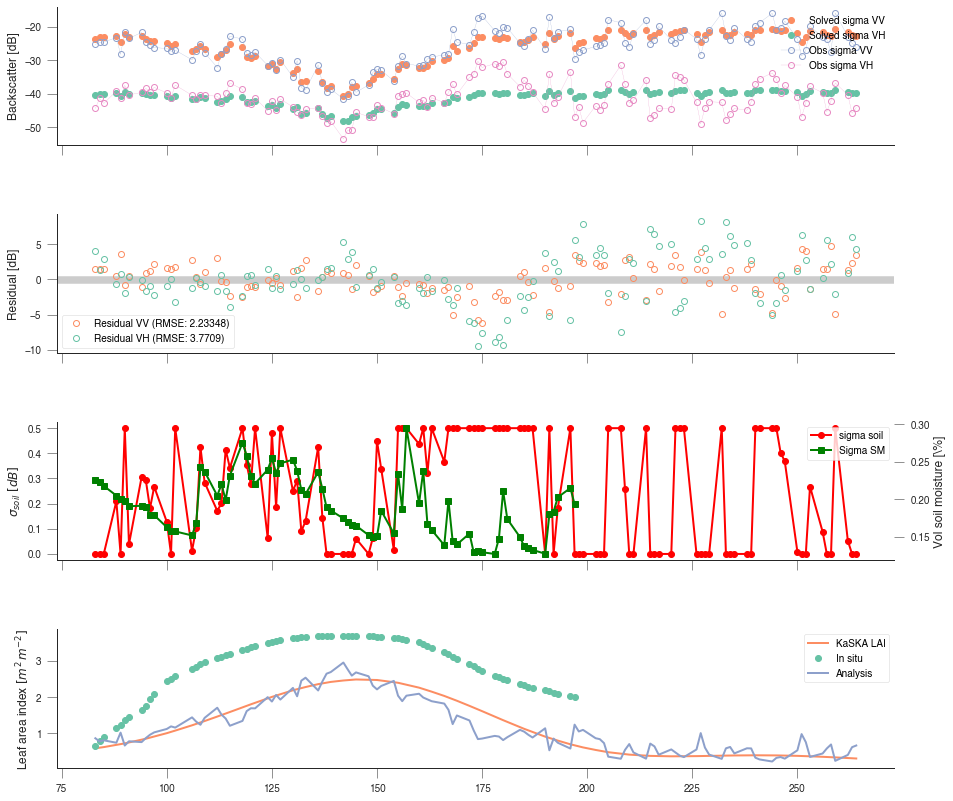

In [11]:
field = "301"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])
gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Again, there's some semblance of results when there's a canopy, but for the "fallow" period, the model is incapable to doing anything. Again, we see that the goodness of fit is inversely related to $LAI$, as in the other cases. And actually, it's mostly the VH polarisation that's worse in terms of fitting.

/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:95: RuntimeWarning: divide by zero encountered in true_divide
  prior_cost = 0.5 * (prior_mean - x) ** 2 / prior_unc ** 2
/home/ucfajlg/python/LMU_SAR_tests/SAR_retrieval_funcs.py:96: RuntimeWarning: divide by zero encountered in true_divide
  dprior_cost = -(prior_mean - x) / prior_unc ** 2


Initial cost 2523.65
Final cost 1323.86


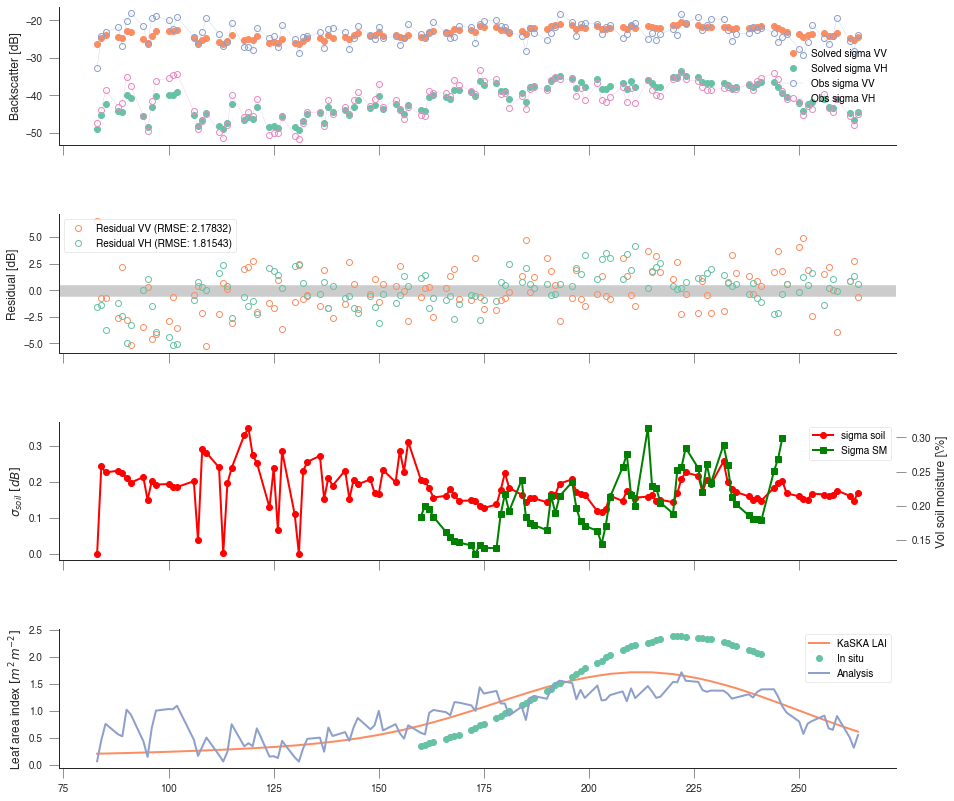

In [12]:
field = "319"
doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = prepare_field_data(
    field, df, df_s2)

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_std = 20. * np.nanstd([df[f"SM_{field:s}"][passer] for field in fields],
                         axis=0)
sm_std[sm_std == 0] = 0.2

prior_mean = np.concatenate([[0, ]*6, sm_mean, s2_lai])
prior_sd = np.concatenate([[0, ]*6, sm_std, [0.1, ]*n_obs])

gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)

Similar comments to above. Note that here the LAI is quite low, and the model underestimates before DoY 175 and tends to overestimate backscatter afterwards. 

So to sum up...
* If you have a canopy, the WCM model with a simple linear relationship between VSM and soil backscatter has some merit.
* However, if there's no canopy, the model appears incapable of coping with observed variations in backscatter and just pushes them to parameters. It appears that this is particularly serious for the VH polarisation, this is probably something that will show up with comparisons with e.g. the Oh models
* Retrieved LAI from optical tends to underestimate the real $LAI$. This might be an artefact of the way it was extracted (there are clear edge effects in the fields), and KaSKA retrievals do appear to be oversmoothed.
* We haven't played with passing funky things to the VOD (e.g. $LAI\cdot C_{ab},\,LAI\cdot C_{brown}, \dots$. Some of this might allow for further finessing of things.
* If we know there's no canopy, we might want to relax the fit to the observations, or possible add different uncertainties to the two polarisations. The justification for this is model error. 
